In [3]:
import pandas as pd

df = pd.read_csv('Data/hourly_data_ff.csv')
time = df['timestamp']
df.drop(columns=['timestamp'], inplace=True)

In [4]:
import numpy as np
dfs = np.array_split(df,10)
times = np.array_split(time,10)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
import matplotlib.pyplot as plt
from Models.TM_G import TM_G
from Model_eval.TM_eval import evaluate_TM
from sklearn.preprocessing import StandardScaler
from Models.CVal import cross_validation
import copy

feature_cols = df.columns.difference(['vol'])
predictions = []
for i in range(4, 9):
  df_train = pd.concat([copy.deepcopy(dfs[j]) for j in range(i-3,i-1)], ignore_index=True).reset_index(drop = True)
  df_validate = copy.deepcopy(dfs[i])
  df_test =copy.deepcopy(dfs[i+1])

  best_params = cross_validation(copy.deepcopy(df_train), copy.deepcopy(df_validate))
  print(f'Cross validated interval {i}')

  model = TM_G(n_features = df_train.shape[1]-1, lb = best_params['lb'], lambda_reg = best_params['lambda_reg'])
  new_df_train = pd.concat([df_train, df_validate], axis=0, ignore_index=True).reset_index(drop = True)
  scaler = StandardScaler()
  new_df_train[feature_cols] = scaler.fit_transform(new_df_train[feature_cols])
  model.train_model(df_train, epochs = 2000)
  df_test[feature_cols] = scaler.transform(df_test[feature_cols])
  print(f'Predicted interval {i+1}')

  _, _, y_pred, _ = evaluate_TM(model, df_test, plot = False)
  predictions.append(y_pred)

100%|██████████| 2000/2000 [00:05<00:00, 356.19it/s, loss=366.880371]


Cross validated interval 4


100%|██████████| 2000/2000 [00:04<00:00, 469.89it/s, loss=25844.330078]  


Predicted interval 5


100%|██████████| 2000/2000 [00:05<00:00, 384.93it/s, loss=138.254028]


Cross validated interval 5


100%|██████████| 2000/2000 [00:05<00:00, 393.07it/s, loss=-48.872459]     


Predicted interval 6


100%|██████████| 2000/2000 [00:05<00:00, 351.34it/s, loss=289.893219]


Cross validated interval 6


100%|██████████| 2000/2000 [00:03<00:00, 571.79it/s, loss=3012255.750000] 


Predicted interval 7


100%|██████████| 2000/2000 [00:05<00:00, 385.17it/s, loss=24.725830]


Cross validated interval 7


100%|██████████| 2000/2000 [00:04<00:00, 480.80it/s, loss=3993688.250000] 


Predicted interval 8


100%|██████████| 2000/2000 [00:04<00:00, 414.59it/s, loss=82.550926]


Cross validated interval 8


100%|██████████| 2000/2000 [00:04<00:00, 434.49it/s, loss=-356.254852]


Predicted interval 9


In [ ]:
final_pred = [predictions[j][i] for j in range(1,len(predictions)) for i in range(len(predictions[j])) ]
print(len(final_pred))
dfs = [dfs[i][31:] for i in range(10)]
merged = pd.concat(dfs[4:], ignore_index=True).reset_index(drop = True)
print(merged.shape)

1375
(1375, 11)


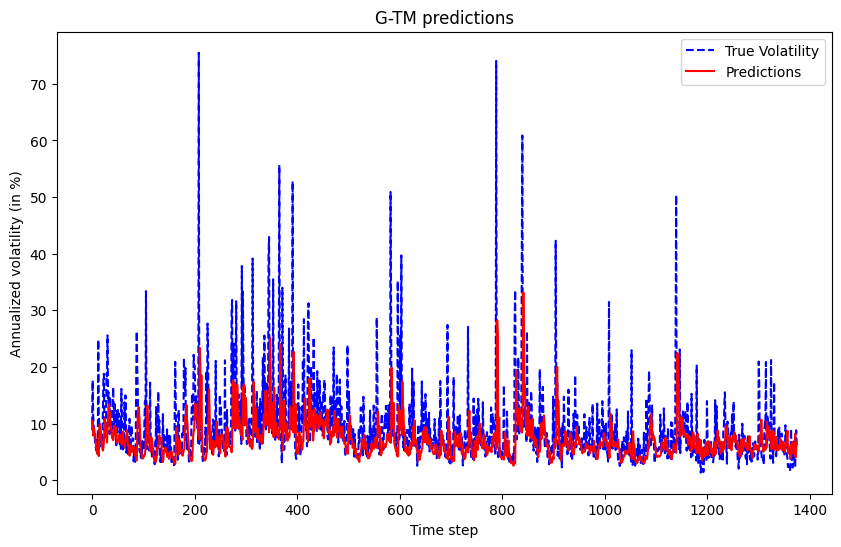

In [12]:
plt.figure(figsize = (10,6))
plt.plot( merged['vol'], label = 'True Volatility', color = 'blue', linestyle = '--')
plt.plot( final_pred, label = 'Predictions', color = 'red')
plt.title('G-TM predictions')
plt.ylabel('Annualized volatility (in %)')
plt.xlabel('Time step')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
for i in range(6):
  start = int(np.sum([len(dfs[j]) for j in range(i)]))
  rmse = np.sqrt(mean_squared_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])])) / 100 # Undo percentage scaling
  mae = mean_absolute_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])]) / 100 
  print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Test RMSE: 0.0739, MAE: 0.0423
Test RMSE: 0.0906, MAE: 0.0540
Test RMSE: 0.0635, MAE: 0.0371
Test RMSE: 0.0871, MAE: 0.0428
Test RMSE: 0.0540, MAE: 0.0287
Test RMSE: 0.0350, MAE: 0.0238


Now the Granger causality test indicates that the only orderbook features that cause the volatility are ask_depth, bid_depth, bid_volume, spread and volume_difference. We thus train the model using only these features to see if this leads to improved performance

In [157]:
dfs = np.array_split(df,10)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [158]:
predictions = []
for i in range(4, 9):
  df_train = pd.concat([copy.deepcopy(dfs[j]) for j in range(i-3,i-1)], ignore_index=True).reset_index(drop = True)
  df_validate = copy.deepcopy(dfs[i])
  df_test =copy.deepcopy(dfs[i+1])

  best_params = cross_validation(copy.deepcopy(df_train), copy.deepcopy(df_validate))
  print(f'Cross validated interval {i}')

  model = TM_G(n_features = df_train.shape[1]-1, lb = best_params['lb'], lambda_reg = best_params['lambda_reg'])
  new_df_train = pd.concat([df_train, df_validate], axis=0, ignore_index=True).reset_index(drop = True)
  scaler = StandardScaler()
  new_df_train[feature_cols] = scaler.fit_transform(new_df_train[feature_cols])
  model.train_model(df_train, epochs = 2000)
  df_test[feature_cols] = scaler.transform(df_test[feature_cols])
  print(f'Predicted interval {i+1}')

  _, _, y_pred, _ = evaluate_TM(model, df_test, plot = False)
  predictions.append(y_pred)

100%|██████████| 2000/2000 [00:04<00:00, 409.72it/s, loss=-133.480560]


Cross validated interval 4


100%|██████████| 2000/2000 [00:04<00:00, 477.39it/s, loss=-2.716812]      


Predicted interval 5


100%|██████████| 2000/2000 [00:04<00:00, 441.34it/s, loss=137.221832]


Cross validated interval 5


100%|██████████| 2000/2000 [00:03<00:00, 620.80it/s, loss=13176.523438]   


Predicted interval 6


100%|██████████| 2000/2000 [00:04<00:00, 442.14it/s, loss=-72.703766]


Cross validated interval 6


100%|██████████| 2000/2000 [00:03<00:00, 506.23it/s, loss=19096.960938]    


Predicted interval 7


100%|██████████| 2000/2000 [00:04<00:00, 442.59it/s, loss=-94.524139]


Cross validated interval 7


100%|██████████| 2000/2000 [00:04<00:00, 417.39it/s, loss=18.207573]      


Predicted interval 8


100%|██████████| 2000/2000 [00:03<00:00, 515.00it/s, loss=-145.268631]


Cross validated interval 8


100%|██████████| 2000/2000 [00:03<00:00, 530.39it/s, loss=-21.349686]     


Predicted interval 9


In [148]:
final_pred = [predictions[j][i] for j in range(1,len(predictions)) for i in range(len(predictions[j])) ]
print(len(final_pred))
dfs = [dfs[i][31:] for i in range(10)]
merged = pd.concat(dfs[4:], ignore_index=True).reset_index(drop = True)
print(merged.shape)

1375
(1375, 11)


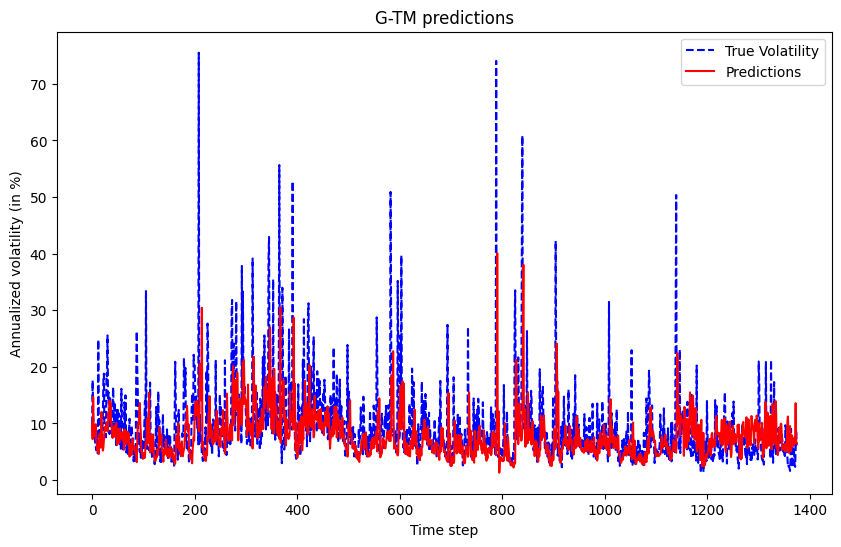

In [149]:
plt.figure(figsize = (10,6))
plt.plot( merged['vol'], label = 'True Volatility', color = 'blue', linestyle = '--')
plt.plot( final_pred, label = 'Predictions', color = 'red')
plt.title('G-TM predictions')
plt.ylabel('Annualized volatility (in %)')
plt.xlabel('Time step')
plt.legend()
plt.show()

In [152]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
for i in range(6):
  start = int(np.sum([len(dfs[j]) for j in range(i)]))
  rmse = np.sqrt(mean_squared_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])])) / 100 # Undo percentage scaling
  mae = mean_absolute_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])]) / 100 
  print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Test RMSE: 0.0762, MAE: 0.0440
Test RMSE: 0.0872, MAE: 0.0541
Test RMSE: 0.0639, MAE: 0.0379
Test RMSE: 0.0902, MAE: 0.0452
Test RMSE: 0.0540, MAE: 0.0298
Test RMSE: 0.0427, MAE: 0.0326
